## Для начала напишем функцию для получения фичей MFCC


In [1]:
import python_speech_features

def get_features(frame,s_r=16000):
    mfcc = python_speech_features.mfcc(frame, s_r, winstep=(10 / 1000), 
                                       winlen=mfcc_4 * (10 / 1000), nfft=2048)
    mfcc = mfcc[:, 1:]
    delta = python_speech_features.delta(mfcc, 2)
    return mfcc, delta

### Получим данные из созданного ранее датасета


In [2]:
import h5py as hp
import numpy as np
f = hp.File('data/data.hdf5', 'r')
labels = np.array(f['labels'])

In [3]:
BATCH_SIZE = 50 #hyperparameters
FRAMES = 30
FEATURES = 24
epochs = 40
learning_rate = 1e-5
momentum = 0.9
OBJ_CUDA = False #nedeed for code from an article

Создадим датасет, взяв по трети из каждого датасета с разным уровнем шума.

In [74]:
dat3 = np.concatenate((f['mfcc--3'],f['delta--3']),axis =1)
dat15 = np.concatenate((f['mfcc--15'],f['delta--15']),axis =1)
dat0 = np.concatenate((f['mfcc-None'],f['delta-None']),axis =1)
n = len(f['labels']) # num of objects
data_full =(np.concatenate((dat0[:n//3],dat15[n//3:-n//3],dat3[-n//3:]),axis=0))
data_l = np.hstack((data_full,labels.reshape((-1,1))))

Получим укороченную версию датасета (10%) (порядка 300 000 объектов) для того, чтобы успеть обучить сеть

In [85]:
def short_data(dat, p=0.1):
    n = len(dat)
    size = int(p * (n//3))
    return np.concatenate((dat[:size],dat[n//3:n//3 + size],dat[int(2*n//3):int(2*n//3) + size]))
short = short_data(data_l,0.2)

Внизу реализация Focal Loss который использовался в статье на которую я опирался https://github.com/nicklashansen/voice-activity-detection. Для архитектуры завязанной на LSTM NN фокал лосс с параметром гамма=2 показал хорошие результаты, но у меня не получилось обучить с ее помощью этой функции, потому использвалась бинарная кроссэнтропия.

In [6]:
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms 
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=0)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [87]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(short[:,:24],short[:,24],shuffle=False)
n = X_train.shape[0]
X_train, X_val = np.split(X_train,[int(0.8*n)])
y_train, y_val = np.split(y_train, [int(0.8*n)])

In [88]:
X_train, y_train, X_test, y_test, X_val, y_val = [torch.Tensor(i) for i in [X_train, y_train, 
                                                                            X_test, y_test, X_val, y_val]]

train_dataset = TensorDataset(X_train,y_train)
test_dataset = TensorDataset(X_test,y_test)

train_dataloader = DataLoader(train_dataset,shuffle=False,
                              batch_size=BATCH_SIZE,drop_last=True)
test_dataloader = DataLoader(test_dataset,shuffle=False,
                             batch_size=BATCH_SIZE,drop_last=True)



Попытка реализовать сеть с архитектурой взятой из статьи 10.1109/ICASSP.2013.6637694. Там была указана архитектура котрой пользовались и в предыдущей статье. Она включает в себя 1 скрытый слой, с 4 блоками по 50 LSTM ячеек. Остальные детали архитектуры см в README.

In [44]:
class NET(nn.Module):
    def __init__(self):
        super(NET, self).__init__()
        self.ls = nn.LSTM(input_size=24, hidden_size=50,num_layers=4)
        self.out = nn.Linear(in_features=50,out_features=2)
    def forward(self,x):
        x,_ = self.ls(x)
        x = (self.out(x))
        return 1/(1+torch.exp(-x))

Обучение

In [89]:

def transform_target(target):
    
    l = []
    for i in range(len(target)):
        if target[i] == 1.:
            l.append([1.,0])
        else:
            l.append([0,1.])

    return torch.tensor(l).unsqueeze(1)


net = NET()
criterion = nn.BCELoss()
optimizer = optimizer = optim.SGD(net.parameters(),lr = learning_rate, momentum=momentum)

for epoch in range(epochs):
    print(f"Epoch: {epoch}")
    for batch_idx, (data, targets) in enumerate(train_dataloader):

        
        data = data.reshape(data.shape[0], -1).unsqueeze(1)
        # forward propagation
        scores = net(data)
        loss = criterion(scores, transform_target(targets).to(torch.float32))

        # zero previous gradients
        optimizer.zero_grad()
        
        # back-propagation
        loss.backward()

        # gradient descent or adam step
        optimizer.step() 

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39


In [90]:
torch.save(net,'net.pickle')

In [92]:
device = torch.device('cpu')
def check_accuracy(loader, model):
    global device
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy"
            f" {float(num_correct) / float(num_samples) * 100:.2f}"
        )

    model.train()
    
check_accuracy(test_dataloader,net)

Got 93474 / 194150 with accuracy 48.15


# Test on data

### WEBRTC 

In [102]:
import os
import glob

In [96]:
import webrtcvad 
from IPython.display import Audio
from scipy.io.wavfile import read
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf  

def get_labels(audio, s_r, frame_duration=10,vad_level_of_agression=1):
    vad=webrtcvad.Vad(vad_level_of_agression)
    samples_per_frame = frame_duration * s_r//1000
    frames = []
    for i in range(int(len(audio)//samples_per_frame)-1):
        frame = np.int16(audio[i*samples_per_frame:(i+1)*samples_per_frame]).tobytes()
        frames.append(vad.is_speech(frame, s_r))
    frames = np.array(frames).repeat(samples_per_frame)
    frames = np.concatenate((frames,np.array([frames[-1]]*(len(audio)-len(frames)))),axis =0)
    return frames

In [146]:
import python_speech_features

def get_features(frame,s_r=16000):
    mfcc = python_speech_features.mfcc(frame, s_r, winstep=(10 / 1000), 
                                       winlen=4 * (10 / 1000), nfft=2048)
    mfcc = mfcc[:, 1:]
    delta = python_speech_features.delta(mfcc, 2)
    return torch.tensor(np.concatenate((mfcc, delta),axis=1)).flo

In [138]:
def get_frames( trackname,l=160, s_r = 16000,):
    '''splits the track into frames of 160 samples (10 ms of 16kHz sampling rate audio)'''
    _,data = read(trackname,s_r)
    i=0
    frames = []
    rem = (len(data)-int(len(data)/160)*160)
    data = (data[:-rem])
    frames = np.split(data,len(data)//160)
    return np.array(frames)

In [178]:
s_r = 16000
tracks = glob.glob('for_devs/*.wav')
results_my = []
resulst_webrtc = []
example = tracks[0]
frames = get_frames(example)
_,data = read(example)

for frame in frames:
    results_my.append((int(net(get_features(frame).float())[0][0]>0.5)))
result_web = get_labels(data,s_r) + 0
results_my = (np.array(results_my).repeat(160))

In [177]:
(np.array(results_my).repeat(160))

41120

In [185]:
Audio(data=data,rate = s_r)

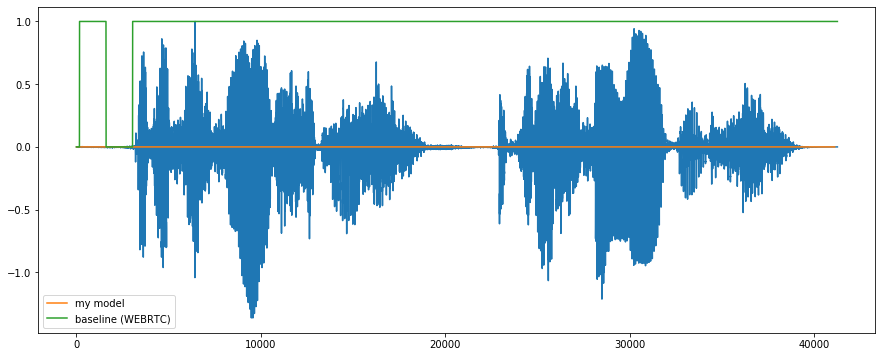

In [188]:
plt.figure(figsize=(15,6))
plt.plot(data/max(data))
plt.plot(results_my,label='my model')
plt.plot(result_web,label='baseline (WEBRTC)')
plt.legend()

# Выводы
Моя модель показала точность 0.48 и как видно даже на одном примере, соверешнно не репрезентативна. Опираясь на статьи, можно сделать вывод, что baseline модель (WEBRTC) крайне неустойчива к шумам, но даже она показывает результат лучше натренированной мной сети. В таких услових я не вижу смысла составлять файл с предсказаниями по всему датасету, так как это все равно будет непоказательно. 